In [132]:
import timeit
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

In [133]:
res: dict[int, dict[int, dict[str, list[float]]]] = {}
# loop size of overall array
for block_nums in [1,2,4,6,8,10,20,40,60,80,100,200,400,800,1000,2000,4000,6000,8000,10000]:
    print("number of blocks:", block_nums)
    res[block_nums] = {}
    # loop size of individual blocks
    for block_size in tqdm([1, 2, 4, 6, 8, 10, 20, 40, 60, 80, 100]):
        res[block_nums][block_size] = {}
        
        res[block_nums][block_size]['dense'] = timeit.repeat("x@y", 
                      "from graphax.sparse.block import BlockSparseTensor, SparseDimension;"
                      "import jax.random as jrand;"
                      "k1, k2 = jrand.split(jrand.PRNGKey(42), 2);"
                      f"x=BlockSparseTensor([SparseDimension(0,{block_nums},0,1)],[SparseDimension(1,{block_nums},0,0)], jrand.normal(k1, ({block_nums},{block_size},{block_size}))).dense();"
                      f"y=BlockSparseTensor([SparseDimension(0,{block_nums},0,1)],[SparseDimension(1,{block_nums},0,0)], jrand.normal(k2, ({block_nums},{block_size},{block_size}))).dense();", 
                      repeat=10, number=1)
        
        n = block_nums*block_size
        res[block_nums][block_size]['dense_mul_sum'] = [n**3, (n-1)*n**2]
        
        res[block_nums][block_size]['naive_square_sparse'] = timeit.repeat("x*y", 
                      "from graphax.sparse.block import BlockSparseTensor, SparseDimension;"
                      "import jax.random as jrand;"
                      "k1, k2 = jrand.split(jrand.PRNGKey(42), 2);"
                      f"x=BlockSparseTensor([SparseDimension(0,{block_nums},0,1)],[SparseDimension(1,{block_nums},0,0)], jrand.normal(k1, ({block_nums},{block_size},{block_size})));"
                      f"y=BlockSparseTensor([SparseDimension(0,{block_nums},0,1)],[SparseDimension(1,{block_nums},0,0)], jrand.normal(k2, ({block_nums},{block_size},{block_size})));", 
                      repeat=10, number=1)
        
        res[block_nums][block_size]['naive_square_sparse_mul_sum'] = [block_size**3*block_nums, (block_size-1)*block_size**2*block_nums]
        

number of blocks: 1


 55%|█████▍    | 6/11 [00:04<00:04,  1.23it/s]


KeyboardInterrupt: 

In [131]:
import json
with open("naive_square_sparse.json", "w") as f:
    json.dump(res, f, sort_keys=True, indent=4)

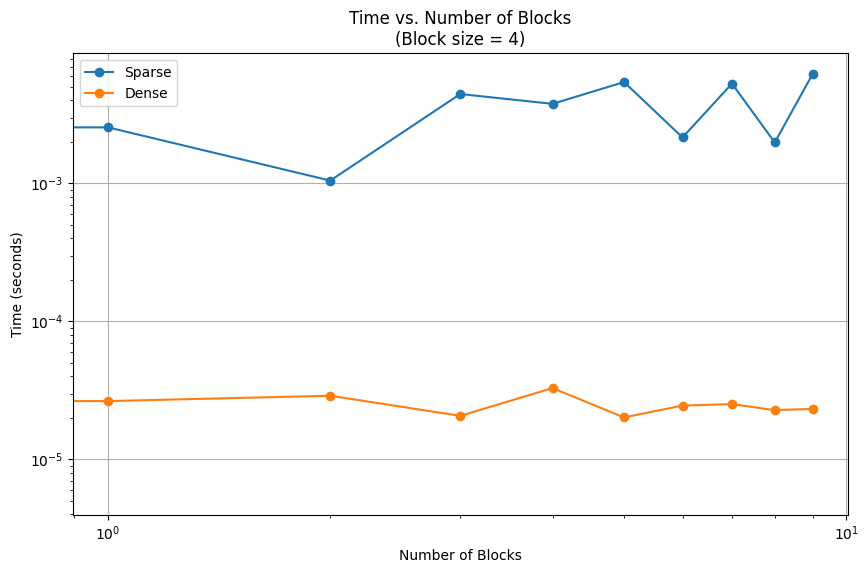

In [128]:
block_size_to_plot = 4
blocks_list = []
sparse_time_list = []
dense_time_list = []

for blocks, block_sizes in res.items():
    if block_size_to_plot in block_sizes:
        blocks_list.append(blocks)
        sparse_time_list.append(np.mean(block_sizes[block_size_to_plot]['sparse']))
        dense_time_list.append(np.mean(block_sizes[block_size_to_plot]['dense']))

plt.figure(figsize=(10, 6))
plt.plot(blocks_list, sparse_time_list, marker='o', label=f"Sparse")
plt.plot(blocks_list, dense_time_list, marker='o', label=f"Dense")
plt.xlabel("Number of Blocks")
plt.ylabel("Time (seconds)")
plt.title(f"Time vs. Number of Blocks\n(Block size = {block_size_to_plot})")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

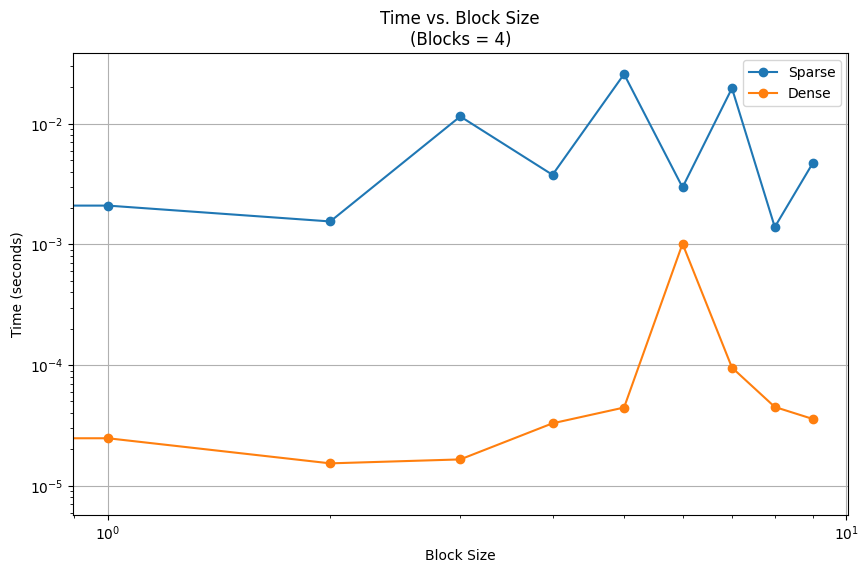

In [129]:
blocks_to_plot = 4
block_sizes_list = []
sparse_time_list = []
dense_time_list = []

if blocks_to_plot in res:
    r = res[blocks_to_plot]
    for block_size in r:
        block_sizes_list.append(block_size)
        sparse_time_list.append(np.mean(r[block_size]['sparse']))
        dense_time_list.append(np.mean(r[block_size]['dense']))

plt.figure(figsize=(10, 6))
plt.plot(block_sizes_list, sparse_time_list, marker='o', label=f"Sparse")
plt.plot(block_sizes_list, dense_time_list, marker='o', label=f"Dense")
plt.xlabel("Block Size")
plt.ylabel("Time (seconds)")
plt.title(f"Time vs. Block Size\n(Blocks = {blocks_to_plot})")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

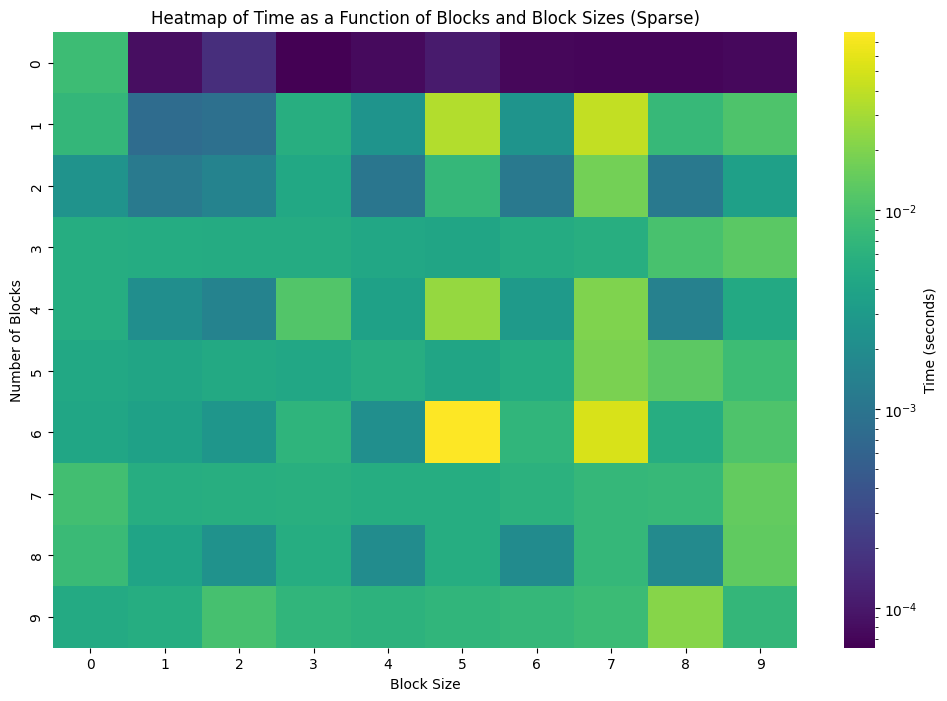

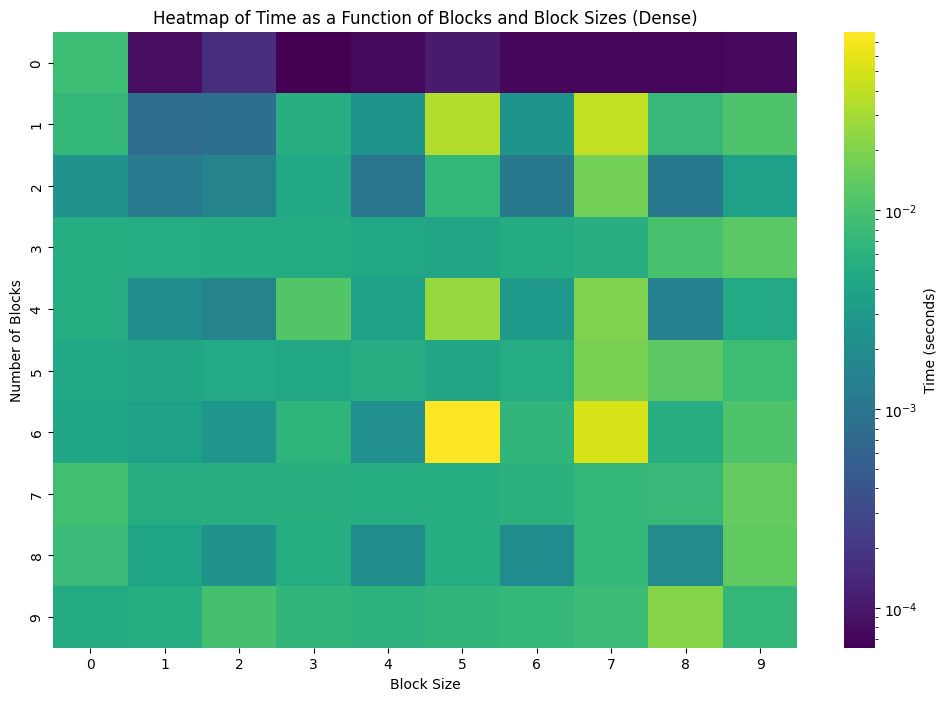

ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x12214d4e0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 1200x800 with 2 Axes>

In [130]:
import numpy as np
import seaborn as sns

sparse_heatmap_data = []
dense_heatmap_data = []
blocks_labels = sorted(res.keys())
block_sizes_labels = sorted(next(iter(res.values())).keys())

for blocks in blocks_labels:
    sparse_row = []
    dense_row = []
    for block_size in block_sizes_labels:
        sparse_row.append(np.mean(res[blocks][block_size]['sparse']))
        dense_row.append(np.mean(res[blocks][block_size]['dense']))
    sparse_heatmap_data.append(sparse_row)
    dense_heatmap_data.append(sparse_row)

sparse_heatmap_data = np.array(sparse_heatmap_data)
dense_heatmap_data = np.array(dense_heatmap_data)

plt.figure(figsize=(12, 8))
sns.heatmap(
    sparse_heatmap_data,
    xticklabels=block_sizes_labels,
    yticklabels=blocks_labels,
    norm=plt.matplotlib.colors.LogNorm(),
    cmap="viridis",
    cbar_kws={"label": "Time (seconds)"}
)
plt.xlabel("Block Size")
plt.ylabel("Number of Blocks")
plt.title("Heatmap of Time as a Function of Blocks and Block Sizes (Sparse)")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(
    dense_heatmap_data,
    xticklabels=block_sizes_labels,
    yticklabels=blocks_labels,
    norm=plt.matplotlib.colors.LogNorm(),
    cmap="viridis",
    cbar_kws={"label": "Time (seconds)"}
)
plt.xlabel("Block Size")
plt.ylabel("Number of Blocks")
plt.title("Heatmap of Time as a Function of Blocks and Block Sizes (Dense)")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(
    dense_heatmap_data-sparse_heatmap_data,
    xticklabels=block_sizes_labels,
    yticklabels=blocks_labels,
    norm=plt.matplotlib.colors.LogNorm(),
    cmap="viridis",
    cbar_kws={"label": "Time (seconds)"}
)
plt.xlabel("Block Size")
plt.ylabel("Number of Blocks")
plt.title("Heatmap of Time as a Function of Blocks and Block Sizes (Dense)")
plt.show()